In this notebook, we will work with the **Pima Indians Diabetes** dataset from Kaggle.

### Context
This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

### Content
The datasets consists of several medical predictor variables and one target variable, **Outcome**. Predictor variables includes the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.

## Imports

In [313]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
from scipy.stats import skew, norm
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score

## EDA

Quick EDA

In [215]:
#load data
data = pd.read_csv('../input/diabetes.csv')

In [216]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [217]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [218]:
y = data.Outcome
X = data.drop('Outcome', axis=1)

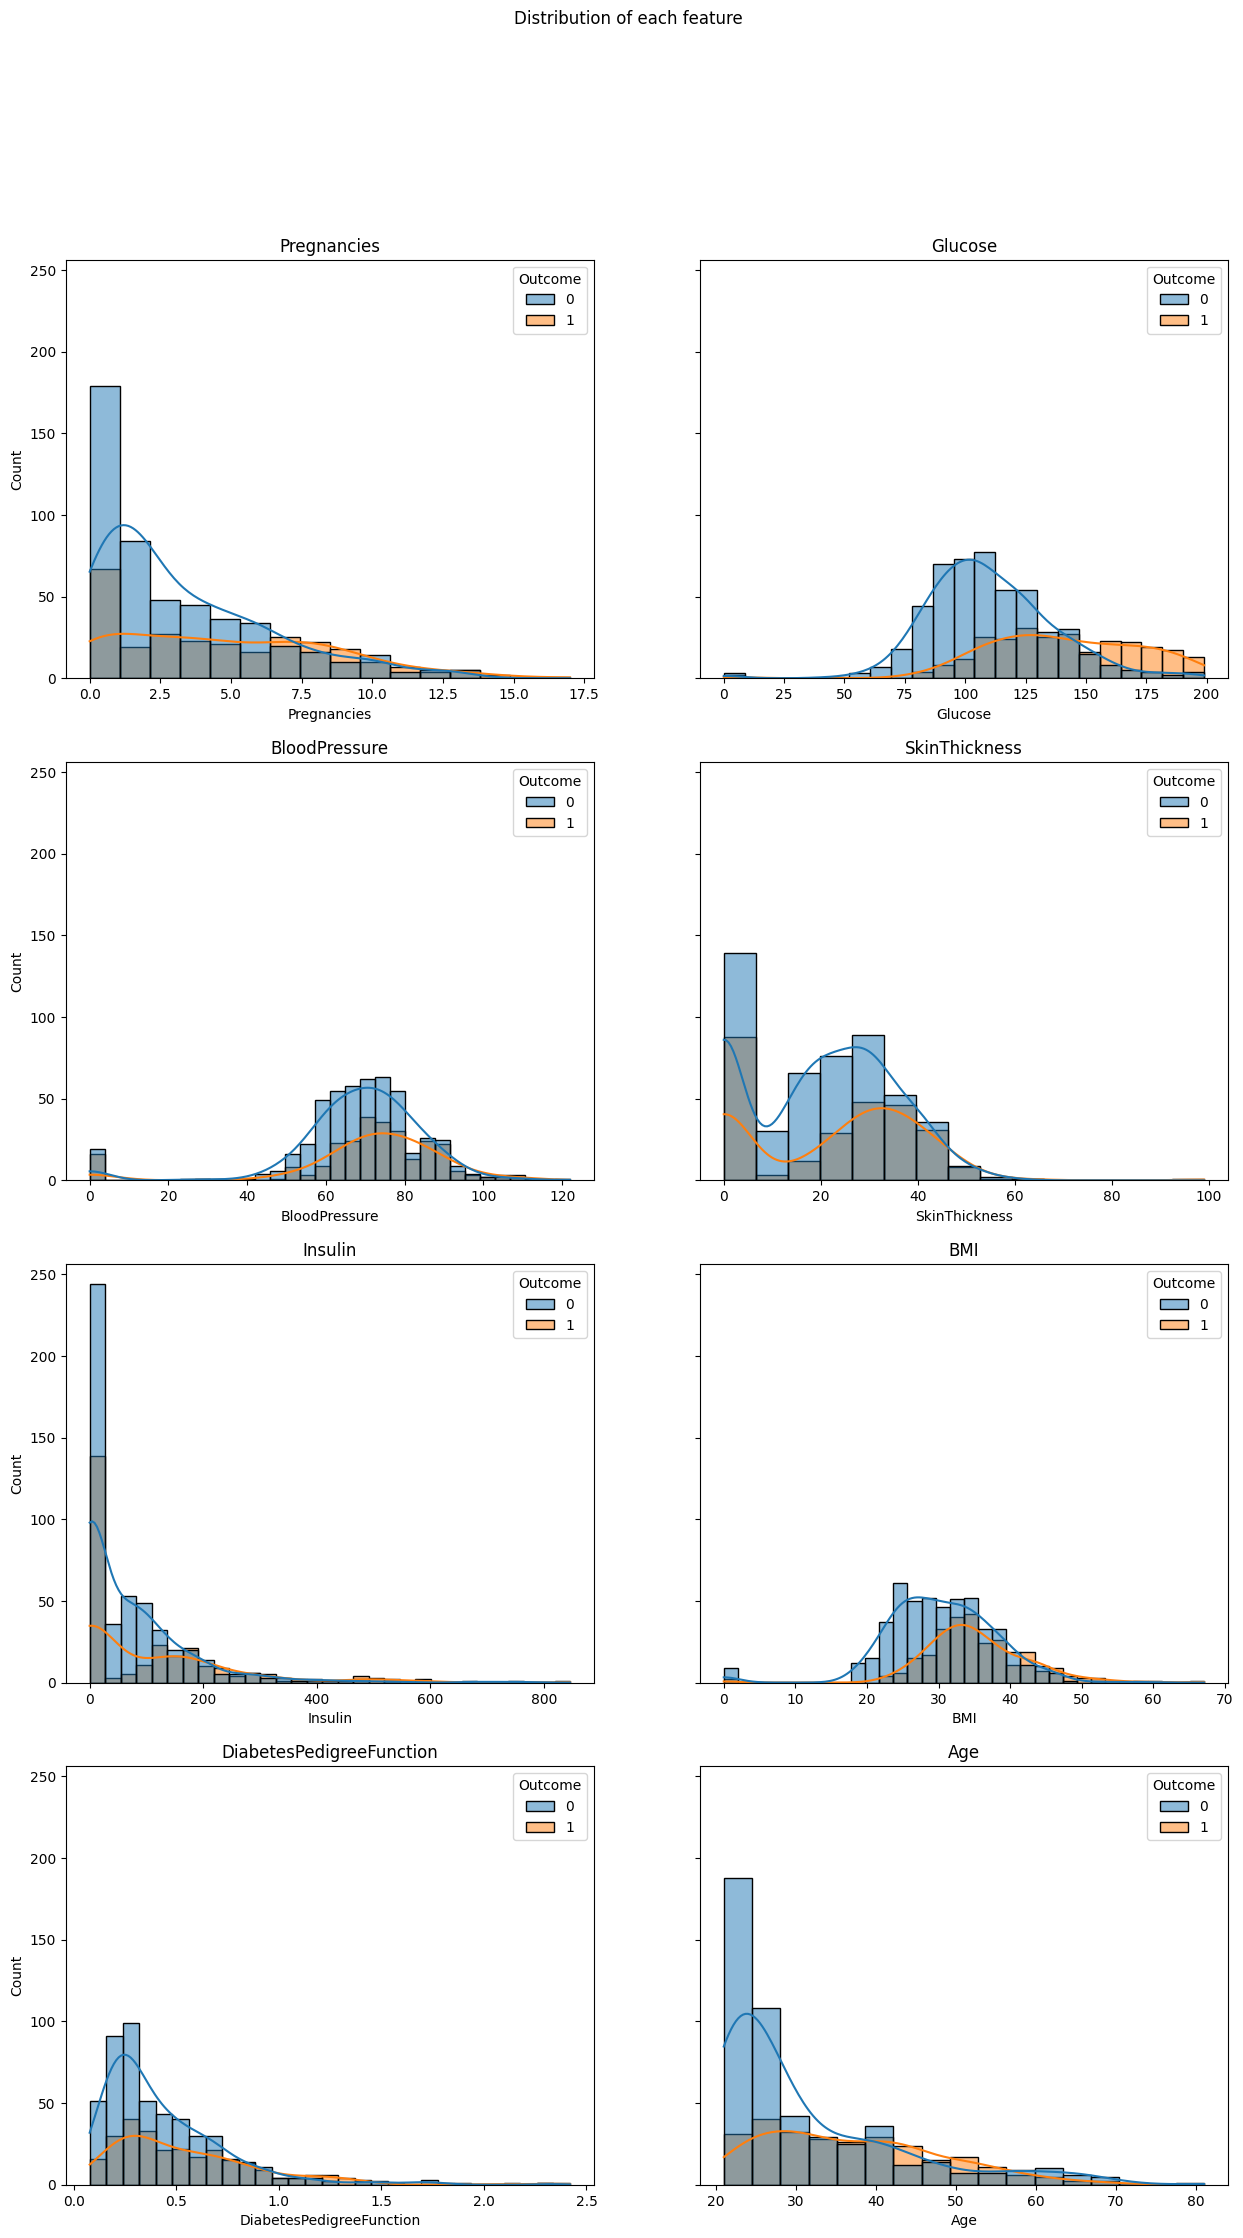

In [219]:
fig, axes = plt.subplots(4, 2, figsize = (15,25), sharey = True)
fig.suptitle('Distribution of each feature')
i=0
j=0
for col in X:
    sns.histplot(data = data, x = col, hue=y, ax=axes[i,j], kde=True)
    axes[i,j].set_title(col)
    j+=1
    if j==2:
        i+=1
        j=0

The dataframe has no NaNs. But several columns contain invalid values 0, such as the column `BMI`: it makes no sense to have a BMI of 0, so we must replace those values by something more logical.

The following columns have invalid values 0 :
- Glucose
- BloodPressure
- SkinThickness
- Insulin
- BMI

In [220]:
invalid_0_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Age']

According to the distribution, it should be interesting to **replace all 0 vaues in these columns by their mean**, as they seem very close to normal distribution, but **for Insulin I would choose to replace with the median** instead, as the distribution is a bit more skewed.

Using the `ColumnSelector` and the `SimpleImputer`, build a preprocessing Pipeline that will fill all invalid 0 values in the selected columns.

In [221]:
# Custom class ColumnSelector

class ColumnSelector(skl.base.TransformerMixin):
    def __init__(self, columns_idx):
        self.columns_idx = columns_idx
        
    def fit(self, X, y=None):        
        return self
        
    def transform(self, X, y=None):        
        if isinstance(X, np.ndarray):
            X_tf = X[:, self.columns_idx]
            
        elif isinstance(X, pd.DataFrame):
            X_tf = X.iloc[:, self.columns_idx]
        return X_tf

### We reduce the number of features to simplify the model

In [285]:
selected_columns = [col for col in X.columns if col not in ['BloodPressure', 'SkinThickness', 'DiabetesPedigreeFunction']]

In [286]:
X_reduced = X[selected_columns]

In [287]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, train_size=0.8, stratify=y, random_state=42)

In [288]:
transformers_pipeline = ColumnTransformer([('median_imput', SimpleImputer(missing_values=0, strategy='median'),[col for col in invalid_0_columns if col in selected_columns])], remainder='passthrough')

In [289]:
rf_pipeline = Pipeline([('transformer', transformers_pipeline), ('estimator', RandomForestClassifier(class_weight='balanced'))])

In [290]:
# Test your preprocessing pipeline

In [291]:
rf_model = rf_pipeline.fit(X_train, y_train)

In [292]:
y_pred = model.predict(X_test)

In [293]:
print(classification_report(y_test, y_pred, target_names=['No diabetes', 'Diabetes']))

              precision    recall  f1-score   support

 No diabetes       0.79      0.86      0.82       100
    Diabetes       0.69      0.57      0.63        54

    accuracy                           0.76       154
   macro avg       0.74      0.72      0.72       154
weighted avg       0.75      0.76      0.75       154



In [294]:
param_grid_rf = {'estimator__n_estimators' : np.linspace(1, 200, 200, dtype='int'), 
              'estimator__criterion' : ['gini', 'entropy'], 
              'estimator__max_depth' : np.linspace(1, 100, 100, dtype='int'),
              'estimator__min_samples_split' : np.linspace(2,10,10, dtype='int'),
              'estimator__min_samples_leaf' : np.linspace(1,10,10, dtype='int')}

In [295]:
randomCV_rf = RandomizedSearchCV(rf_pipeline, param_grid_rf, n_iter = 30, n_jobs=-1, random_state=42)

In [296]:
rf_model_optimized = randomCV_rf.fit(X_train, y_train)

In [297]:
y_pred_opti = rf_model_optimized.predict(X_test)

In [298]:
print(classification_report(y_test, y_pred_opti, target_names=['No diabetes', 'Diabetes']))

              precision    recall  f1-score   support

 No diabetes       0.85      0.74      0.79       100
    Diabetes       0.61      0.76      0.68        54

    accuracy                           0.75       154
   macro avg       0.73      0.75      0.73       154
weighted avg       0.77      0.75      0.75       154



In [303]:
y_pred_train = rf_model_optimized.predict(X_train)

In [304]:
print(classification_report(y_train, y_pred_train, target_names=['No diabetes', 'Diabetes']))

              precision    recall  f1-score   support

 No diabetes       0.92      0.82      0.87       400
    Diabetes       0.73      0.87      0.79       214

    accuracy                           0.84       614
   macro avg       0.82      0.85      0.83       614
weighted avg       0.85      0.84      0.84       614



## Testing a SVC

In [305]:
svc_pipeline = Pipeline([('transformer', transformers_pipeline), ('estimator', SVC(class_weight='balanced'))])

In [314]:
param_grid_svc = {'estimator__C' : norm(loc=1, scale=0.05),
                  'estimator__kernel' : ['rbf', 'linear', 'poly', 'sigmoid'],
                  'estimator__degree' : np.linspace(1, 5, 1, dtype='int')}

In [315]:
randomCV_svc = RandomizedSearchCV(svc_pipeline, param_grid_svc, n_iter = 30, n_jobs=-1, random_state=42)

In [316]:
svc_model = randomCV_svc.fit(X_train, y_train)

In [317]:
y_pred_svc = svc_model.predict(X_test)

In [318]:
print(classification_report(y_test, y_pred_svc, target_names=['No diabetes', 'Diabetes']))

              precision    recall  f1-score   support

 No diabetes       0.78      0.79      0.79       100
    Diabetes       0.60      0.59      0.60        54

    accuracy                           0.72       154
   macro avg       0.69      0.69      0.69       154
weighted avg       0.72      0.72      0.72       154



In [319]:
y_pred_train_svc = svc_model.predict(X_train)

In [321]:
print(classification_report(y_train, y_pred_train_svc, target_names=['No diabetes', 'Diabetes']))

              precision    recall  f1-score   support

 No diabetes       0.82      0.81      0.82       400
    Diabetes       0.66      0.67      0.66       214

    accuracy                           0.76       614
   macro avg       0.74      0.74      0.74       614
weighted avg       0.76      0.76      0.76       614

